1. PyTorch Basics
    - Toy example with PyTorch
2. Image Classification with PyTorch
    - Implement a simple MLP network for image classification
    - Implement a convolutional network for image classification
    - Experiment with different numbers of layers and optimizers
    - Push the performance of your CNN

This is inspired and adopted from the official PyTorch tutorial.


In this you would need to use **Python 3.6+** along with the following packages:
```
1. pytorch 1.2
2. torchvision
3. numpy
4. matplotlib
```
To install pytorch, please follow the instructions on the [Official website](https://pytorch.org/). In addition, the [official document](https://pytorch.org/docs/stable/) could be very helpful when you want to find certain functionalities. 

You can also consider to use Google Colab, where PyTorch has been installed.

# Section 1. PyTorch Basics

Simply put, PyTorch is a **Tensor** library like Numpy. These two libraries similarly provide useful and efficient APIs for you to deal with your tensor data. What really differentiate PyTorch from Numpy are the following two features:
1. Numerical operations that can **run on GPUs** (more than 10x speedup)
2. Automatic differentiation for building and training neural networks

In this section, we will walk through some simple example, and see how the automatic differentiation functionality can make your life much easier.

### To select GPU in Google Colab:
- go to **Edit -> Notebook settings -> Hardware accelerator -> GPU**

In [ ]:
import torch # import pytorch.
import torch.nn.functional as F
import torch.nn as nn
import time
import numpy as np

In [ ]:
dtype = torch.float
device = torch.device("cpu")

#device = torch.device("cuda:0") # Uncomment this to run on GPU
#print(torch.cuda.get_device_name(0)) # Check GPU Device name

## 1.1. Automatic Differentiation
Gradient descent is the driving force of the deep learning field. In the lectures and assignment 1, we learned how to derive the gradient for a given function, and implement methods for calculating and performing gradient descents. We also see how we can manually implement the backward and forward functions for the simple NN example. While implementing these functions may not be a big deal for a small network, it may get very nasty when we want to build something with tens of hundreds of layers.

In PyTorch (as well as other major deep learning libraries), we can use autograd ([automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation)) to handle the tedious computation of backward passes. When doing forward passes with autograd, we are essentially defining a **computational graph**, while the nodes in the graph are **tensors**, the edges are the functions that produce output tensors (e.g. ReLU, Linear, Convolutional Layer) given the input tensors. To do backpropagation, we can simply backtrack through this graph to compute gradients. 

This may sound a little bit abstract, so let's take a look at the example:

In [ ]:
target = 10.

# create a matrix of size 2x2. Each with value draws from standard normal distribution.
x = torch.randn(2, 2, requires_grad=True) 
y = torch.randn(2, 2, requires_grad=True)

a = x + y
b = a.sum()
loss = b - target

# print out each tensor:
print(x)
print(y)
print(a)
print(b)
print(loss)

print("-----gradient-----")
print(x.grad)
print(y.grad)

tensor([[0.3196, 0.0816],
        [0.4063, 0.0914]], requires_grad=True)
tensor([[ 1.7505, -0.1379],
        [-0.6293,  1.1000]], requires_grad=True)
tensor([[ 2.0701, -0.0562],
        [-0.2230,  1.1914]], grad_fn=<AddBackward0>)
tensor(2.9823, grad_fn=<SumBackward0>)
tensor(-7.0177, grad_fn=<SubBackward0>)
-----gradient-----
None
None


In the above example, we have seen a few things:
1. `requires_grad` flag: If false, we can safely exclude this tensor (and its subgraph) from gradient computation and therefore increase efficiency.
2. `grad_fn`: we can see that once an operation is done to a tensor, the output tensor is bound to a backward function associated to the operation. In this case, we have Add, Sum, and Sub.

However, even if we set `requires_grad=True`, we still don't have gradient for `x` and `y`. This is because we haven't performed the backpropagation yet. So let's do it:

In [ ]:
# perform backpropagation from this "node"
loss.backward()
print('-----gradient-----')
print(x.grad)
print(y.grad)

-----gradient-----
tensor([[1., 1.],
        [1., 1.]])
tensor([[1., 1.],
        [1., 1.]])


Great, seems like we can perform gradient descent without writing backwards function! Now, let's see a simple toy example on how we can fit some weights `w1` and `w2` with random input `x` and target `y`: 

In [ ]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold input and outputs.
# Setting requires_grad=False indicates that we do not need to compute gradients
# with respect to these Tensors during the backward pass.
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

# Create random Tensors for weights.
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
w1 = torch.randn(D_in, H, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, dtype=dtype, requires_grad=True)

learning_rate = 1e-6
for t in range(500):
    # Forward pass: compute predicted y using operations on Tensors; these
    # are exactly the same operations we used to compute the forward pass using
    # Tensors, but we do not need to keep references to intermediate values since
    # we are not implementing the backward pass by hand.
    y_pred = x.mm(w1).clamp(min=0).mm(w2)

    # Compute and print loss using operations on Tensors.
    # Now loss is a Tensor of shape (1,)
    # loss.item() gets the scalar value held in the loss.
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(f'iteration {t}: {loss.item()}')
    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call w1.grad and w2.grad will be Tensors holding the gradient
    # of the loss with respect to w1 and w2 respectively.
    loss.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.  (because we don't need the gradient for the operation 
    # learning_rate * w1.grad)
    # An alternative way is to operate on weight.data and weight.grad.data.
    # Recall that tensor.data gives a tensor that shares the storage with
    # tensor, but doesn't track history.
    # You can also use torch.optim.SGD to achieve this.
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad

        # Manually zero the gradients after updating weights
        w1.grad.zero_()
        w2.grad.zero_()

iteration 99: 400.50018310546875
iteration 199: 1.7080515623092651
iteration 299: 0.012404250912368298
iteration 399: 0.00029732612892985344
iteration 499: 4.7837071178946644e-05


## 1.2. `nn` Module
Computational graphs and autograd are a very powerful paradigm for defining complex operators and automatically taking derivatives; however for large neural networks raw autograd can be a bit too low-level.

When building neural networks we frequently think of arranging the computation into layers, some of which have learnable parameters which will be optimized during learning.

In PyTorch, the nn package serves this purpose. The nn package defines a set of Modules, which are roughly equivalent to neural network layers. A Module receives input Tensors and computes output Tensors, but may also hold internal state such as Tensors containing learnable parameters. The nn package also defines a set of useful loss functions that are commonly used when training neural networks.

Now, let's see how our simple NN could be implemented using the nn module.

In [ ]:
import torch.nn as nn
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.ReLU(),
    nn.Linear(H, D_out),
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = nn.MSELoss(reduction='sum')

learning_rate = 1e-4
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(x)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(f'iteration {t}: {loss.item()}')

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

iteration 99: 1.5049192905426025
iteration 199: 0.012853206135332584
iteration 299: 0.0002441557589918375
iteration 399: 6.900499101902824e-06
iteration 499: 2.416988706954726e-07


So far, we have been updating the model parameters manually with `torch.no_grad()`. However, if we want to use optimization algorithms other than SGD, it might get a bit nasty to do it manually. Instead of manually doing this, we can use `optim` pacakge to help optimize our model: 

In [ ]:
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model and loss function.
model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.ReLU(),
    nn.Linear(H, D_out),
)
loss_fn = torch.nn.MSELoss(reduction='sum')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. 
learning_rate = 1e-4
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(f'iteration {t}: {loss.item()}')

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

iteration 99: 2.1223771572113037
iteration 199: 0.030736837536096573
iteration 299: 0.0009377116221003234
iteration 399: 4.3822918087244034e-05
iteration 499: 2.526700200178311e-06


Sometimes you will want to specify models that are more complex than a sequence of existing Modules; for these cases you can define your own Modules by subclassing nn.Module and defining a forward which receives input Tensors and produces output Tensors using other modules or other autograd operations on Tensors.

For example, we can implement our 2-layer simple NN as the following:

In [ ]:
class TwoLayerNet(nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred


# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Construct our model by instantiating the class defined above
model = TwoLayerNet(D_in, H, D_out)

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
for t in range(500):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if t % 100 == 99:
        print(f'iteration {t}: {loss.item()}')

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

iteration 99: 2.9425978660583496
iteration 199: 0.06729263067245483
iteration 299: 0.0034955861046910286
iteration 399: 0.0002523306757211685
iteration 499: 2.0842238882323727e-05


## 1.3. Warm-up: Two-moon datasets
Now, let's use PyTorch to solve some synthetic datasets. In previous assignment, we have to write some codes to create training batches. Again, this can also be done with PyTorch `DataLoader`. The `DataLoader` utilizes parallel workers to read and prepare batches for you, which can greatly speedup the code when your time bottleneck is on file I/O.

Here, we show a simple example that can create a dataloader from numpy data:

### Setup for Google Colab (Skip for Jupyter Notebook)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Find path to your data folder in drive and enter for "path_to_dataset"
path_to_dataset = '/content/drive/My Drive/Deep Learning/Assignment_2/data'
# For Jupyter notebook give path from your local PC

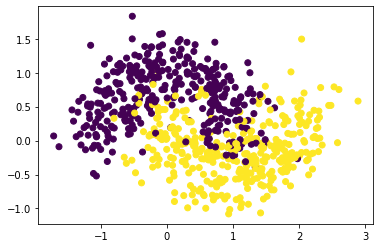

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

X_train = np.loadtxt(path_to_dataset + '/X1_train.csv', delimiter=',')
X_test = np.loadtxt(path_to_dataset + '/X1_test.csv', delimiter=',')
y_train = np.loadtxt(path_to_dataset + '/y1_train.csv', delimiter=',')
y_test = np.loadtxt(path_to_dataset + '/y1_test.csv', delimiter=',')

# Plot it to see why is it called two-moon dataset
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train);

Now, let's create a PyTorch `DataLoader`:

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 64 # mini-batch size
num_workers = 4 # how many parallel workers are we gonna use for reading data
shuffle = True # shuffle the dataset

# Convert numpy array import torch tensor
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train.reshape(-1, 1))
y_test = torch.LongTensor(y_test.reshape(-1, 1))

# First, create a dataset from torch tensor. A dataset define how to read data
# and process data for creating mini-batches.
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          num_workers=num_workers, shuffle=shuffle)

In [ ]:
print(X_train.shape)
print(y_train.shape)

torch.Size([700, 2])
torch.Size([700, 1])


Below, we provide a simple example on how to train your model with this dataloader:

In [ ]:
epoch = 5 # an epoch means looping through all the data in the datasets
lr = 1e-1

# create a simple model that is probably not gonna work well
model = nn.Linear(X_train.size(1), 1)
optim = torch.optim.SGD(model.parameters(), lr=lr)

for e in range(epoch):
    loss_epoch = 0
    # loop through train loader to get x and y
    for x, y in train_loader:
        optim.zero_grad()
        y_pred = model(x)
        # !!WARNING!!
        # THIS IS A CLASSIFICATION TASK, SO YOU SHOULD NOT
        # USE THIS LOSS FUNCTION. 
        loss = (y_pred - y.float()).abs().mean()
        loss.backward()
        optim.step()
        loss_epoch += loss.item()
    print(f'Epcoh {e+1}: {loss_epoch}')

Epcoh 1: 6.287397176027298
Epcoh 2: 3.1801482439041138
Epcoh 3: 2.947307139635086
Epcoh 4: 2.898352399468422
Epcoh 5: 2.897049754858017


### 1.3.1 Your Simple NN
Now, it is time for you to implement your own model for this classification task. Your job here is to:
1. Complete the SimpleNN class. It should be a 2- or 3-layer NN with proper non-linearity.
2. Train your model with SGD optimizer.
3. Tune your model a bit so you can achieve at least 80% accuracy on training set.
Hint: you might want to look up `nn.ReLU`, `nn.Sigmoid`, `nn.BCELoss` in the [official document](https://pytorch.org/docs/stable/). You are allowed to freely pick the hyperparameters of your model.
4. **Please note this is a binary classification problem.**

In [ ]:
class SimpleNN(nn.Module):
    
    def __init__(self, D_in, H, D_out):
        super(SimpleNN, self).__init__()
        ################################################################################
        # TODO:                                                                        #
        # Construct your small feedforward NN here.                                    #
        ################################################################################
        self.fc = nn.Sequential(nn.Linear(D_in, H),
                                nn.ReLU(),
                                nn.Linear(H, H),                                
                                nn.ReLU(),
                                nn.Linear(H, D_out),
                                nn.Sigmoid()
                                )       
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # feed the input to your network, and output the predictions.                  #
        ################################################################################
        out = self.fc(x)
        return out
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

In [ ]:
# helper function for computing accuracy
def get_acc(pred, y):
    pred = pred.float()
    y = y.float()
    return (y==pred).sum().float()/y.size(0)*100.

In [ ]:
epoch = 10 # an epoch means looping through all the data in the datasets
lr = 1e-1

# create a simple model that is probably not gonna work well

################################################################################
# TODO:                                                                        #
# Initialize your model and SGD optimizer here.                                #
################################################################################
model = SimpleNN(D_in=X_train.shape[1], H=128, D_out=1 ) 
optim = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################
print_every = 1

for e in range(epoch):
    loss_per_epoch = 0  # record accmulative loss for each epoch
    ################################################################################
    # TODO:                                                                        #
    # Loop through the dataloader and train your model with nn.BCELoss.            #
    ################################################################################
    for x, y in train_loader:
      model.train()
      optim.zero_grad()
      #forward pass
      y_pred = model(x)
      loss = criterion(y_pred, y.float())
      #backward pass
      loss.backward()
      optim.step()
      loss_per_epoch += loss.item()
    if e % print_every == 0:
      with torch.no_grad():
        model.eval()
        y_pred = (model(X_train) > 0.5)
        train_acc = get_acc(y_pred, y_train)        
      print(f'Epcoh {e+1}: {loss_per_epoch}, Training accuracy: {train_acc}')    

Epcoh 1: 175.69801330566406, Training accuracy: 53.14285659790039
Epcoh 2: 163.93745517730713, Training accuracy: 76.14286041259766
Epcoh 3: 149.43914890289307, Training accuracy: 78.14286041259766
Epcoh 4: 135.1939582824707, Training accuracy: 79.42857360839844
Epcoh 5: 122.69386386871338, Training accuracy: 80.14285278320312
Epcoh 6: 112.03748607635498, Training accuracy: 80.42857360839844
Epcoh 7: 103.87800884246826, Training accuracy: 80.42857360839844
Epcoh 8: 97.95762014389038, Training accuracy: 80.71428680419922
Epcoh 9: 93.56882953643799, Training accuracy: 81.0
Epcoh 10: 90.28441905975342, Training accuracy: 81.71428680419922


Evaluate your accuracy:

In [ ]:
y_pred = (model(X_train) > 0.5)
train_acc = get_acc(y_pred, y_train)

y_pred = (model(X_test) > 0.5)
test_acc = get_acc(y_pred, y_test)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

Training accuracy: 81.71428680419922, Testing accuracy: 83.66666412353516


# Section 2. Image Classification with CNN
Now, we are back to the image classification problem. In this section, our goal is to, again, train models on CIFAR-10 to perform image classification. Your tasks here are to:
1. Build and Train a simple feed-forward Neural Network (consists of only nn.Linear layer with activation function) for the classification task
2. Build and Train a **Convolutional** Neural Network (CNN) for the classification task
3. Try different settings for training your CNN
4. Reproduce

In the following cell, we provide the code for creating a CIFAR10 dataloader. As you can see, PyTorch's `torchvision` package actually has an interface for the CIFAR10 dataset: 

In [ ]:
import torchvision
import torchvision.transforms as transforms

# Preprocessing steps on the training/testing data. You can define your own data augmentation
# here, and PyTorch's API will do the rest for you.
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# This will automatically download the dataset for you if it cannot find the data in root
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


## 2.1 Simple NN
Implement a simple feed-forward neural network, and train it on the CIFAR-10 training set. Here's some specific requirements:
1. The network should only consists of `nn.Linear` layers and the activation functions of your choices (e.g. `nn.Tanh`, `nn.ReLU`, `nn.Sigmoid`, etc). 
2. Train your model with `torch.optim.SGD` with the hyperparameters you like the most. 

Note that the hyperparameters work in previous assignment might not work the same, as the implementations of layers could be different.

In [ ]:
# Set device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### 2.1.1 Design and training

In [ ]:
class SimpleNN(nn.Module):
    
    def __init__(self, D_in, H, D_out):
        super(SimpleNN, self).__init__()
        self.D_in = D_in
        self.D_out = D_out
        ################################################################################
        # TODO:                                                                        #
        # Construct your small feedforward NN here.                                    #
        ################################################################################
        self.fc = nn.Sequential(nn.Linear(self.D_in, H),
                                nn.ReLU(),
                                nn.Linear(H, 128),                                
                                nn.ReLU(),
                                nn.Linear(128, 256), 
                                nn.ReLU(),
                                nn.Linear(256, self.D_out)                               
                                ) 
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
    def forward(self, x):
        # note that: here, the data is of the shape (B, C, H, W)
        # where B is the batch size, C is color channels, and H
        # and W is height and width.
        # To feed it into the linear layer, we need to reshape it
        # with .view() function.
        batch_size = x.size(0)
        x = x.view(batch_size, -1) # reshape the data from (B, C, H, W) to (B, C*H*W)
        ################################################################################
        # TODO:                                                                        #
        # Forward pass, output the prediction score.                                   #
        ################################################################################
        out = self.fc(x)
        return out
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

In [ ]:
epoch = 10
lr = 1e-2
n_input = 3072
n_classes = 10
H = 64
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=8)

################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################
model = SimpleNN(D_in=n_input, H=H, D_out=n_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=lr)

for e in range(epoch):
  model.train()
  loss_per_epoch = 0
  for x, y in train_loader:
    x = x.to(device)
    y = y.to(device)
    optim.zero_grad()
    #forward pass
    y_pred = model(x)
    loss = criterion(y_pred, y)
    #backward pass
    loss.backward()
    optim.step()
    loss_per_epoch += loss.item()
  print(f'Epcoh {e+1}: {loss_per_epoch}')
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

Epcoh 1: 1571.2740021944046
Epcoh 2: 1324.7482823133469
Epcoh 3: 1232.3335175514221
Epcoh 4: 1173.9157831668854
Epcoh 5: 1128.9998208284378
Epcoh 6: 1091.8224670886993
Epcoh 7: 1062.1408520936966
Epcoh 8: 1034.2445068359375
Epcoh 9: 1010.0154585838318
Epcoh 10: 988.6545689105988


Now evaluate your model with the helper function:

In [ ]:
def get_model_acc(model, loader):
    ys = []
    y_preds = []    
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        ys.append(y)
        # set the prediction to the one that has highest value
        # Note that the the output size of model(x) is (B, 10)
        y_preds.append(torch.argmax(model(x), dim=1))
    y = torch.cat(ys, dim=0)
    y_pred = torch.cat(y_preds, dim=0)
    print((y == y_pred).sum())
    return get_acc(y_pred, y)

### 2.1.2 Evaluate NN
Evaluate your NN. You should get an accuracy around **50%** on training set and **49%** on testing set.

In [ ]:
with torch.no_grad():
  model.eval()
  train_acc = get_model_acc(model, train_loader)
  test_acc = get_model_acc(model, test_loader)
  print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

tensor(28118, device='cuda:0')
tensor(5006, device='cuda:0')
Training accuracy: 56.236000061035156, Testing accuracy: 50.05999755859375


## 2.2 Convolutional Neural Network (CNN)
Convolutional layer has been proven to be extremely useful for vision-based task. As mentioned in the lecture, this speical layer allows the model to learn filters that capture crucial visual features. 



### 2.2.1 Implement and Evaluate CNN
In this section, you will need to construct a CNN for classifying CIFAR-10 image. Specifically, you need to:
1. build a `CNNClassifier` with `nn.Conv2d`, `nn.Maxpool2d` and activation functions that you think are appropriate. 
2. You would need to flatten the output of your convolutional networks with `view()`, and feed it into a `nn.Linear` layer to predict the class labels of the input. 

Once you are done with your module, train it with `optim.SGD`, and evaluate it. You should get an accuracy around **55%** on training set and **53%** on testing set.

Hint: You might want to look up `nn.Conv2d`, `nn.Maxpool2d`, `nn.CrossEntropyLoss()`, `view()` and `size()`.

In [ ]:
class CNNClassifier(nn.Module):
    
    def __init__(self, inp_channels, out_classes):
        super(CNNClassifier, self).__init__()
        ################################################################################
        # TODO:                                                                        #
        # Construct a CNN with 2 or 3 convolutional layers and 1 linear layer for      #
        # outputing class prediction. You are free to pick the hyperparameters         #
        ################################################################################
        self.inp_channels = inp_channels
        self.out_classes = out_classes

        self.cnn= nn.Sequential(            
            nn.Conv2d(self.inp_channels, 128, kernel_size=3,  padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),      
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),

            nn.Conv2d(128, 256, kernel_size=3,  padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),      
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
                    )
        self.fc = nn.Sequential(
            nn.Linear(256*8*8, self.out_classes),
            )
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################        
        
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Forward pass of your network. First extract feature with CNN, and predict    #
        # class scores with linear layer. Be careful about your input/output shape.    #
        ################################################################################
        #print(self.cnn(x).shape)
        batch_size = x.size(0)      
        return self.fc(self.cnn(x).view(batch_size, -1))        
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

In [ ]:
# You can tune these hyperparameters as you like.
epoch = 15
lr = 1e-1
n_input_channels = 3
out_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=8)

################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################
model = CNNClassifier(inp_channels=n_input_channels, out_classes=out_classes)
model = model.to(device)
optim = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
start_time = time.time()
for e in range(epoch):  
  model.train()
  loss_per_epoch = 0
  for x, y in train_loader:
    x = x.to(device)
    y = y.to(device)
    optim.zero_grad()
    #forward pass
    y_pred = model(x)
    loss = criterion(y_pred, y)
    #backward pass
    loss.backward()
    optim.step()
    loss_per_epoch += loss.item()  
  print(f'Epcoh {e+1}: {loss_per_epoch}')
end_time = time.time()
total_time = end_time - start_time
print(f"Time taken to execute the training loop is {np.floor(total_time)} seconds")  
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

Epcoh 1: 1848.124501466751
Epcoh 2: 921.4337480664253
Epcoh 3: 796.7792166471481
Epcoh 4: 728.2929726243019
Epcoh 5: 678.7903335094452
Epcoh 6: 641.1675462126732
Epcoh 7: 608.4853229522705
Epcoh 8: 581.1300250589848
Epcoh 9: 554.5808143615723
Epcoh 10: 525.9232038855553
Epcoh 11: 500.98602053523064
Epcoh 12: 479.24907982349396
Epcoh 13: 456.0347394347191
Epcoh 14: 434.4372520595789
Epcoh 15: 411.97570019960403
Time taken to execute the training loop is 96.0 seconds


In [ ]:
# turn on evaluation mode. This is crucial when you have BatchNorm in your network,
# as you want to use the running mean/std you obtain durining training time to normalize
# your input data. Rememeber to call .train() function after evaluation
with torch.no_grad():
  model.eval()
  train_acc = get_model_acc(model, train_loader)
  test_acc = get_model_acc(model, test_loader)
  print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

tensor(40411, device='cuda:0')
tensor(7034, device='cuda:0')
Training accuracy: 80.8219985961914, Testing accuracy: 70.33999633789062


### 2.2.2 STACK MORE LAYERS
Now, **try at least 4 network architectures with different numbers of convolutional layers**. Train these settings with `optim.SGD`, plot the training/testing accuracy as a fuction of convolutional layers and describe what you have observed (running time, performance, etc). **Please make sure your figures are with clear legends and labels**.

In [ ]:
# common initialization

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
criterion = nn.CrossEntropyLoss()
n_classes = 10
lr=1e-1

In [ ]:
# evaluation function 
def model_eval(model,train_loader,test_loader):
  model.eval()
  train_acc = get_model_acc(model, train_loader)
  test_acc = get_model_acc(model, test_loader)
  print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')
  return float(train_acc),float(test_acc)  

In [ ]:
# solver function for NN training

def Solver_NN (model, train_loader, optim, criterion, epoch=501, lr=1e-1, print_every=20):
  model = model.to(device)
  starttime=time.time()
  for e in range(epoch):
    loss_epoch=0

    for x,y in train_loader:
      model.train()
      x = x.to(device)
      y =y.to(device)
      optim.zero_grad()
      batch_size=y.shape[0]      
      #print("y is:",y.shape)---> y is: torch.Size([64, 10])
      y_pred=model(x)
      #print("y_pred is:",y_pred.shape)---> y_pred is: torch.Size([64, 10])
      loss=criterion(y_pred,y)
      loss.backward()
      optim.step()
      loss_epoch += loss.item()
      
    if e % print_every==0:
      print("loss_epoch",e, loss_epoch)
    endtime=time.time()
      
  return model,endtime-starttime

####2.2.2 Architecture 1

In [ ]:
# Architecture 1: 1 convolution layer 1 fully connected layer

class Architecture_1(nn.Module):

  def __init__(self,D_out):
    super(Architecture_1,self).__init__()
    self.conv1=nn.Conv2d(3,6,3)
    self.fc1=nn.Linear(1350,D_out)

  def forward(self,x):
    x=F.max_pool2d(F.relu(self.conv1(x)),2)
    x=x.view(-1, self.flat_features(x))
    y_pred=self.fc1(x)
    return F.softmax(y_pred,dim=1)

  def flat_features(self, x):
    size = x.size()[1:]  
    num_features = 1
    for s in size:
      num_features *= s
    return num_features


In [ ]:
# Training of first architecture

model = Architecture_1(n_classes)
optim = torch.optim.SGD(model.parameters(), lr=lr)
modle,time_1 = Solver_NN(model,train_loader,optim,criterion,epoch=51,lr=1e-1,print_every=20)


loss_epoch 0 1659.8100378513336
loss_epoch 20 1452.608170390129
loss_epoch 40 1428.9423788785934


In [ ]:
# Model evaluation
with torch.no_grad():
  model.eval()
  train_acc_1 = get_model_acc(model, train_loader)
  test_acc_1 = get_model_acc(model, test_loader)
  print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')
  print("Total time taken to execute architecture 1:",np.floor(time_1/60),"minutes")

tensor(29964, device='cuda:0')
tensor(5337, device='cuda:0')
Training accuracy: 80.8219985961914, Testing accuracy: 70.33999633789062
Total time taken to execute architecture 1: 5.0 minutes


####2.2.2 Architecture 2

In [ ]:
# Architecture 2: 2 convolution layer 1 fully connected layer

class Architecture_2(nn.Module):    
    def __init__(self,D_out):
        super(Architecture_2, self).__init__()
        self.conv1=nn.Conv2d(3,16,3)
        self.conv2=nn.Conv2d(16,32,3)
        self.linear1=nn.Linear(1152,D_out)
    
    def flat_features(self,x):
        size = x.size()[1:]  
        num_features = 1
        for s in size:
          num_features *= s
        return num_features    
        
    def forward(self, x):
        x=F.max_pool2d(F.relu(self.conv1(x)),2)
        x=F.max_pool2d(F.relu(self.conv2(x)),2)
        x=x.view(-1, self.flat_features(x))
        y_pred=self.linear1(x)
        return F.softmax(y_pred,dim=1)

In [ ]:
# Training of second architecture
model = Architecture_2(n_classes)
optim = torch.optim.SGD(model.parameters(), lr=lr)
modle,time_2 = Solver_NN(model,train_loader,optim,criterion,epoch=51,lr=1e-1,print_every=20)

loss_epoch 0 1682.5546048879623
loss_epoch 20 1431.0463063716888
loss_epoch 40 1409.3187897205353


In [ ]:
# Model evaluation
with torch.no_grad():
  model.eval()
  train_acc_2 = get_model_acc(model, train_loader)
  test_acc_2 = get_model_acc(model, test_loader)
  print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')
  print("Total time taken to execute architecture 2:",np.floor(time_2/60),"minutes")

tensor(32666, device='cuda:0')
tensor(5948, device='cuda:0')
Training accuracy: 80.8219985961914, Testing accuracy: 70.33999633789062
Total time taken to execute architecture 2: 6.0 minutes


#### 2.2.2 Architecture 3

In [ ]:
# Architecture 3: 3 convolution layer 1 fully connected layer

class Architecture_3(nn.Module):    
    def __init__(self,D_out):
        super(Architecture_3, self).__init__()
        self.conv1=nn.Conv2d(3,6,3)
        self.conv2=nn.Conv2d(6,16,3)
        self.conv3=nn.Conv2d(16,32,3)
        self.linear1=nn.Linear(576,D_out)

    def flat_features(self,x):
        size = x.size()[1:] 
        num_features = 1
        for s in size:
          num_features *= s
        return num_features    
        
    def forward(self, x):
        x=F.max_pool2d(F.relu(self.conv1(x)),2)
        x=F.max_pool2d(F.relu(self.conv2(x)),2)
        x=x.view(-1, self.flat_features(x))
        y_pred=self.linear1(x)
        return F.softmax(y_pred,dim=1)

In [ ]:
# Training of third architecture
model = Architecture_3(n_classes)
optim = torch.optim.SGD(model.parameters(), lr=lr)
modle,time_3 = Solver_NN(model,train_loader,optim,criterion,epoch=51,lr=1e-1,print_every=20)

loss_epoch 0 1718.1336311101913
loss_epoch 20 1439.7194821834564
loss_epoch 40 1433.2903089523315


In [ ]:
# Model evaluation
with torch.no_grad():
  model.eval()
  train_acc_3 = get_model_acc(model, train_loader)
  test_acc_3 = get_model_acc(model, test_loader)
  print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')
  print("Total time taken to execute architecture 3:",np.floor(time_3/60),"minutes")

tensor(31044, device='cuda:0')
tensor(5878, device='cuda:0')
Training accuracy: 80.8219985961914, Testing accuracy: 70.33999633789062
Total time taken to execute architecture 3: 6.0 minutes


####2.2.2 Architecture 4

In [ ]:
# Architecture 4: 4 convolution layer 1 fully connected layer

class Architecture_4(nn.Module):    
    def __init__(self,D_out):
        super(Architecture_4, self).__init__()

        self.conv1=nn.Conv2d(3,6,3)
        self.conv2=nn.Conv2d(6,16,3)
        self.conv3=nn.Conv2d(16,32,3)
        self.conv4=nn.Conv2d(32,64,3)
        self.linear1=nn.Linear(256,D_out)        

    def flat_features(self,x):
        size = x.size()[1:] 
        num_features = 1
        for s in size:
          num_features *= s
        return num_features    
        
    def forward(self, x):
        x=F.relu(self.conv1(x))
        x=F.max_pool2d(F.relu(self.conv2(x)),2)
        x=F.relu(self.conv3(x))
        x=F.max_pool2d(F.relu(self.conv4(x)),5)        
        x=x.view(-1, self.flat_features(x))
        y_pred=self.linear1(x)
        return F.softmax(y_pred,dim=1)

In [ ]:
# Training of forth architecture
model = Architecture_4(n_classes)
optim = torch.optim.SGD(model.parameters(), lr=lr)
modle,time_4=Solver_NN(model,train_loader,optim,criterion,epoch=51,lr=1e-1,print_every=20)

loss_epoch 0 1774.9383907318115
loss_epoch 20 1464.6752924919128
loss_epoch 40 1846.4793665409088


In [ ]:
# Model evaluation
with torch.no_grad():
  model.eval()
  train_acc_4 = get_model_acc(model, train_loader)
  test_acc_4 = get_model_acc(model, test_loader)
  print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')
print("Total time taken to execute architecture 3:",np.floor(time_4/60),"minutes")

tensor(4998, device='cuda:0')
tensor(1000, device='cuda:0')
Training accuracy: 80.8219985961914, Testing accuracy: 70.33999633789062
Total time taken to execute architecture 3: 6.0 minutes


In [ ]:
# plotting accuracy 
conv_layer=[1,2,3,4]
time_list=[time_1/60,time_2/60,time_3/60,time_4/60]
train_accuracy=[train_acc_1,train_acc_2,train_acc_3,train_acc_4]
test_accuracy=[test_acc_1,test_acc_2,test_acc_3,test_acc_4]

print("convolution layers:",conv_layer)
print("time taken:",time_list)
print("train accuracy: ",train_accuracy)
print("test accuracy: ",test_accuracy)

convolution layers: [1, 2, 3, 4]
time taken: [5.949123938878377, 6.2328135887781775, 6.249791657924652, 6.443557314078013]
train accuracy:  [tensor(59.9280, device='cuda:0'), tensor(65.3320, device='cuda:0'), tensor(62.0880, device='cuda:0'), tensor(9.9960, device='cuda:0')]
test accuracy:  [tensor(53.3700, device='cuda:0'), tensor(59.4800, device='cuda:0'), tensor(58.7800, device='cuda:0'), tensor(10.0000, device='cuda:0')]


Text(0.5, 0, 'Number of Convolution Layers')

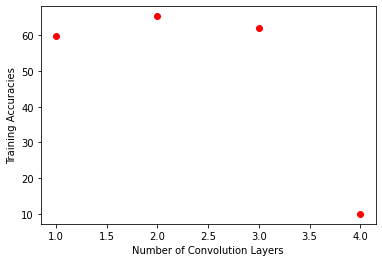

In [ ]:
plt.plot(conv_layer,train_accuracy,'ro')
plt.ylabel('Training Accuracies')
plt.xlabel('Number of Convolution Layers')

Text(0.5, 0, 'Number of Convolution Layers')

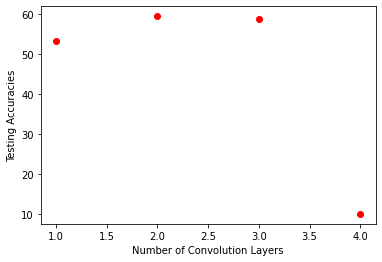

In [ ]:
plt.plot(conv_layer,test_accuracy,'ro')
plt.ylabel('Testing Accuracies')
plt.xlabel('Number of Convolution Layers')

Text(0.5, 0, 'Number of Convolution Layers')

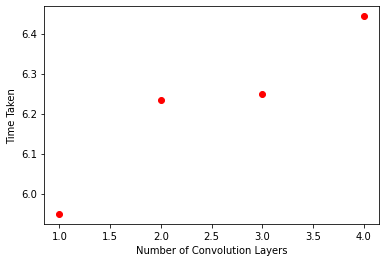

In [ ]:
plt.plot(conv_layer,time_list,'ro')
plt.ylabel('Time Taken')
plt.xlabel('Number of Convolution Layers')

### 2.2.3 Optimizer? Optimizer!
So far, we only use SGD as our optimizer. Now, pick two other optimizers, train your favorite CNN models, and compare the performance you get. What did you see?

####ASGD

In [ ]:
################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################
epoch = 15
lr = 1e-1
n_input_channels = 3
out_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=8)

model = CNNClassifier(inp_channels=n_input_channels, out_classes=out_classes)
model = model.to(device)
optim = torch.optim.ASGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start_time = time.time()
for e in range(epoch):  
  model.train()
  loss_per_epoch = 0
  for x, y in train_loader:
    x = x.to(device)
    y = y.to(device)
    optim.zero_grad()
    #forward pass
    y_pred = model(x)
    loss = criterion(y_pred, y)
    #backward pass
    loss.backward()
    optim.step()
    loss_per_epoch += loss.item()  
  print(f'Epcoh {e+1}: {loss_per_epoch}')
end_time = time.time()
total_time = end_time - start_time
print(f"Time taken to execute the training loop is {np.floor(total_time)} seconds")
with torch.no_grad():
  model.eval()
  train_acc = get_model_acc(model, train_loader)
  test_acc = get_model_acc(model, test_loader)
  print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')  
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

Epcoh 1: 1789.9744527339935
Epcoh 2: 877.6084138154984
Epcoh 3: 757.0503795742989
Epcoh 4: 676.338152885437
Epcoh 5: 616.4140462577343
Epcoh 6: 567.689550101757
Epcoh 7: 528.1395924985409
Epcoh 8: 490.6578414440155
Epcoh 9: 460.8674835264683
Epcoh 10: 425.8060773015022
Epcoh 11: 399.98363034427166
Epcoh 12: 371.06649796664715
Epcoh 13: 344.0134539604187
Epcoh 14: 317.48354287445545
Epcoh 15: 292.21043133735657
Time taken to execute the training loop is 99.0 seconds
tensor(41794, device='cuda:0')
tensor(6995, device='cuda:0')
Training accuracy: 83.58799743652344, Testing accuracy: 69.94999694824219


#### ADAM

In [ ]:
################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################
epoch = 15
lr = 1e-1
n_input_channels = 3
out_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=8)

model = CNNClassifier(inp_channels=n_input_channels, out_classes=out_classes)
model = model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start_time = time.time()
for e in range(epoch):  
  model.train()
  loss_per_epoch = 0
  for x, y in train_loader:
    x = x.to(device)
    y = y.to(device)
    optim.zero_grad()
    #forward pass
    y_pred = model(x)
    loss = criterion(y_pred, y)
    #backward pass
    loss.backward()
    optim.step()
    loss_per_epoch += loss.item()  
  print(f'Epcoh {e+1}: {loss_per_epoch}')
end_time = time.time()
total_time = end_time - start_time
print(f"Time taken to execute the training loop is {np.floor(total_time)} seconds")  
with torch.no_grad():
  model.eval()
  train_acc = get_model_acc(model, train_loader)
  test_acc = get_model_acc(model, test_loader)
  print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

Epcoh 1: 5464.410979986191
Epcoh 2: 1806.8083250522614
Epcoh 3: 1807.565086364746
Epcoh 4: 1807.3427579402924
Epcoh 5: 1808.016051530838
Epcoh 6: 1806.9712190628052
Epcoh 7: 1807.853481054306
Epcoh 8: 1807.576355457306
Epcoh 9: 1807.5924625396729
Epcoh 10: 1807.9151401519775
Epcoh 11: 1812.5880377292633
Epcoh 12: 1806.6752436161041
Epcoh 13: 1808.2384593486786
Epcoh 14: 1808.150095462799
Epcoh 15: 1808.0302906036377
Time taken to execute the training loop is 101.0 seconds
tensor(5000, device='cuda:0')
tensor(1000, device='cuda:0')
Training accuracy: 9.999999046325684, Testing accuracy: 9.999999046325684


### 2.2.4 Improve Your Model
Again, we want you to play with your model a bit harder, and improve it. You are free to use everything you can find in the documents (`BatchNorm`, `SeLU`, etc), as long as it is not a **predefined network architectures in PyTorch package**. You can also implement some famous network architectures to push the performance. 

(A simple network with 5-6 `nn.Conv2d` can give you at least 70% accuracy on testing set).

In [ ]:
class ImprovedCNNClassifier(nn.Module):
    
    def __init__(self, inp_channels, out_classes):
        super(ImprovedCNNClassifier, self).__init__()
        ################################################################################
 
        ################################################################################
        self.inp_channels = inp_channels
        self.out_classes = out_classes

        self.cnn= nn.Sequential(    
                  nn.Conv2d(self.inp_channels, 64, kernel_size=3,  padding=1),
                  nn.BatchNorm2d(num_features=64),
                  nn.ReLU(),      
                  nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),               

                  nn.Conv2d(64,128,kernel_size=3,padding=1),
                  nn.BatchNorm2d(num_features=128),
                  nn.ReLU(),            
                  nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)),

                  nn.Conv2d(128, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(num_features=256),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)),            

                  nn.Conv2d(256,512,kernel_size=3,padding=1),
                  nn.BatchNorm2d(num_features=512),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))                               
                    )
        
        self.fc = nn.Sequential(
                  nn.Linear(512*2*2, self.out_classes)
                                )
            
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################        
        
    def forward(self, x):
        ################################################################################
        
        ################################################################################
        batch_size = x.size(0)
        return self.fc(self.cnn(x).view(batch_size, -1))
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

In [ ]:
# You can tune these hyperparameters as you like.
epoch = 15
lr = 1e-1
n_input_channels = 3
out_classes = 10
batch_size = 64
num_workers = num_workers

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=8)

################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################
model = ImprovedCNNClassifier(inp_channels=n_input_channels, out_classes=out_classes)
model = model.to(device)
optim = torch.optim.ASGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
for e in range(epoch):  
  loss_per_epoch = 0
  for x, y in train_loader:
    x = x.to(device)
    y = y.to(device)
    optim.zero_grad()
    #forward pass
    y_pred = model(x)
    loss = criterion(y_pred, y)
    #backward pass
    loss.backward()
    optim.step()
    loss_per_epoch += loss.item()
  print(f'Epcoh {e}: {loss_per_epoch}')
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

Epcoh 0: 1641.8123282790184
Epcoh 1: 845.3395230174065
Epcoh 2: 651.4943274855614
Epcoh 3: 533.4737193584442
Epcoh 4: 447.5976009964943
Epcoh 5: 371.1997924298048
Epcoh 6: 300.29603050649166
Epcoh 7: 228.73108843714
Epcoh 8: 163.40552857518196
Epcoh 9: 109.26212782040238
Epcoh 10: 58.95695037022233
Epcoh 11: 30.62287332280539
Epcoh 12: 10.39679919788614
Epcoh 13: 4.7324338116450235
Epcoh 14: 3.0281314443564042


In [ ]:
with torch.no_grad():
  model.eval()
  train_acc = get_model_acc(model, train_loader)
  test_acc = get_model_acc(model, test_loader)
  print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

tensor(50000, device='cuda:0')
tensor(8283, device='cuda:0')
Training accuracy: 100.0, Testing accuracy: 82.83000183105469
